# Drug Name Detection using YOLO Object Detection

---

## Team Information


> *Iby — Data Preprocessing & Annotation Validation*  
> *Colt — Evaluation & Report Writing*  
> *Sebastian  — Model Development & Training*
>
>
>
> *We chose this project because we wanted to explore how artificial intelligence can be applied in healthcare to improve medication safety and automate visual inspection processes.*

---

## Project Overview

This project focuses on developing a **YOLO (You Only Look Once) object detection model** capable of detecting and identifying **drug names** from images of pharmaceutical packaging.  
By automating the process of locating and reading drug names, this system could support applications such as:
- Pharmacy inventory management  
- Counterfeit drug detection  
- Automated label verification for hospitals and supply chains  

Our goal is to train, test, and evaluate a **YOLO object detection model** that can accurately locate and classify drug name regions from images using bounding boxes.

**Why YOLO?**  
YOLO is a state-of-the-art object detection algorithm that can detect and localize objects in real-time. Unlike traditional CNNs used for image classification, YOLO is specifically designed for object detection tasks, making it ideal for locating drug names with precise bounding box coordinates in pharmaceutical packaging images.

---

## Dataset Description

We are using the **[Drug Name Detection Dataset](https://www.kaggle.com/datasets/pkdarabi/the-drug-name-detection-dataset)** created by *Pk Darabi* on Kaggle.  
This dataset contains approximately **1,823 annotated images** of pharmaceutical packaging, each labeled to mark the location of **drug names** on the product.

**Dataset Highlights:**
- Images of medicine boxes, bottles, and blister packs  
- Bounding-box annotations highlighting the printed drug names  
- Designed for **object detection and text localization** tasks  
- Publicly available for research and experimentation  
- Already formatted with YOLO-compatible annotations (data.yaml file included)

This dataset is perfectly suited for training **YOLO** models, as it provides the bounding box annotations required for object detection.

---

## What is YOLO?

**YOLO (You Only Look Once)** is a state-of-the-art real-time object detection system that can identify and locate multiple objects in an image in a single forward pass through a neural network.

**Key Advantages of YOLO:**
- **Real-time Performance** — Fast inference speeds suitable for live applications
- **Single-Stage Detection** — Detects objects in one pass, unlike two-stage detectors
- **High Accuracy** — Achieves competitive mAP (mean Average Precision) scores
- **Bounding Box Localization** — Provides precise coordinates for detected objects

**YOLO vs. CNN:**
- **CNN (Convolutional Neural Network)**: Typically used for image classification (predicting what category an entire image belongs to)
- **YOLO**: Designed for object detection (locating and identifying multiple objects within an image with bounding boxes)

In this project, we use **YOLO** to detect and localize drug names within packaging images, providing both the location (bounding box) and confidence score for each detection.

---

## Objectives

1. Preprocess and explore the Drug Name Detection dataset in YOLO format.  
2. Train a **YOLO object detection model** for drug name detection.  
3. Evaluate model performance using object detection metrics such as **mAP (mean Average Precision)**, precision, recall, and IoU (Intersection over Union).  
4. Visualize predictions with bounding boxes overlaid on test images.  
5. Discuss potential real-world applications and limitations.

---

## Project Structure (Preview)

- **Section 1:** Data Loading and Exploration  
- **Section 2:** Data Preprocessing and YOLO Format Validation  
- **Section 3:** YOLO Model Training  
- **Section 4:** Evaluation and Results (mAP, Precision, Recall)  
- **Section 5:** Discussion and Conclusion  

---

## Notes

> *This notebook serves as both documentation and an experimental log for our YOLO model training process. All findings, observations, and reflections will be recorded here for reproducibility.*

> It is recommended to use Python 3.12 as the Kernel for this project.

> **Project Evolution:**  
> This project represents an improvement over a previous CNN-based approach. The original CNN model achieved ~70% accuracy for image classification, but was limited to classifying entire images. By switching to YOLO, we can now perform true object detection, locating drug names with bounding boxes—a more appropriate approach for this task given the dataset's bounding box annotations.

> As of rightnow, no changes to the code have been made from the previous project

---



In [1]:
# Download the dataset using kagglehub
import kagglehub
import os
import shutil

# Download latest version
dataset_path = kagglehub.dataset_download("pkdarabi/the-drug-name-detection-dataset")
print("Path to dataset files:", dataset_path)

# Create a local 'data' directory in the current working directory
# This makes the dataset accessible with a consistent path for all users
data_dir = os.path.join(os.getcwd(), "data")

# If data directory doesn't exist or is empty, copy from kagglehub cache
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    print(f"Copying dataset to local 'data' directory: {data_dir}")
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    shutil.copytree(dataset_path, data_dir)
    print("Dataset copied successfully!")
else:
    print(f"Using existing data directory: {data_dir}")

print(f"\nDataset location: {data_dir}")
print(f"Contents: {os.listdir(data_dir)}")

Path to dataset files: /Users/sebastianmojica/.cache/kagglehub/datasets/pkdarabi/the-drug-name-detection-dataset/versions/1
Copying dataset to local 'data' directory: /Users/sebastianmojica/Documents/GitHub/YoloComputerVision/data
Dataset copied successfully!

Dataset location: /Users/sebastianmojica/Documents/GitHub/YoloComputerVision/data
Contents: ['valid', 'test', 'data.yaml', 'train']


In [ ]:
# Points to the dataset for YOLO training
# Uses the local 'data' directory created in Cell 1
import os

# Get the current working directory and construct the data path
data_dir = os.path.join(os.getcwd(), "data")

# Verify the dataset exists
if os.path.exists(data_dir) and os.path.exists(os.path.join(data_dir, "train")):
    print(f"✓ Using local data directory: {data_dir}")
    print(f"✓ Dataset structure verified")
else:
    print(f"✗ Error: Dataset not found at {data_dir}")
    print("  Please run Cell 1 to download the dataset first.")
    data_dir = None


✓ Using local data directory: /Users/sebastianmojica/Documents/GitHub/YoloComputerVision/data
✓ Dataset structure verified


In [3]:
print(os.listdir(data_dir))


['valid', 'test', 'data.yaml', 'train']


In [4]:
# creats path when loading images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 1823 images belonging to 3 classes.


In [5]:

# libraries for CNN

import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# loads images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#splitting your images automatically between training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# model is taking data(images) from the train folder
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    subset='training'
)
# model is taking data(images) from the validation folder
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    subset='validation'
)


Found 1459 images belonging to 3 classes.
Found 364 images belonging to 3 classes.


In [7]:
#define CNN model
model = models.Sequential([
    # first convolution and max pooling block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(3,3),
     # first dropout
    layers.Dropout(0.3),

    #second convolution and max pooling block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(3,3),
    # second dropout
    layers.Dropout(0.3),

    # Third convolutional block (NEW)
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(3,3),
    # Third dropout
    layers.Dropout(0.25),


  # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])
model.summary()

/Users/sebastianmojica/Documents/GitHub/YoloComputerVision/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,219 (942.26 KB)

 Trainable params: 241,219 (942.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compiles our data
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # use categorical because labels are one-hot encoded
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.6943 - loss: 0.8432 - val_accuracy: 0.7005 - val_loss: 0.9100
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.6998 - loss: 0.8267 - val_accuracy: 0.7005 - val_loss: 0.9885
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.6998 - loss: 0.8205 - val_accuracy: 0.7005 - val_loss: 0.8838
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.6998 - loss: 0.8088 - val_accuracy: 0.7005 - val_loss: 0.8992
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.6998 - loss: 0.8103 - val_accuracy: 0.7005 - val_loss: 0.8961
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.6998 - loss: 0.8116 - val_accuracy: 0.7005 - val_loss: 0.8865
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.6998 - loss: 0.8082 - val_accuracy: 0.7005 - val_loss: 0.8582
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.6998 - loss: 0.8064 - val_accuracy: 

In [10]:
# Evaluate on Test Set
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7005 - loss: 0.8472
Validation Accuracy: 0.7005
Validation Loss: 0.8472


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


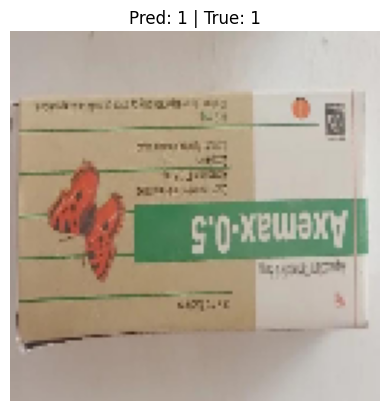

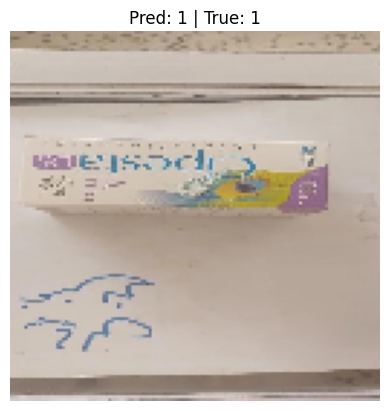

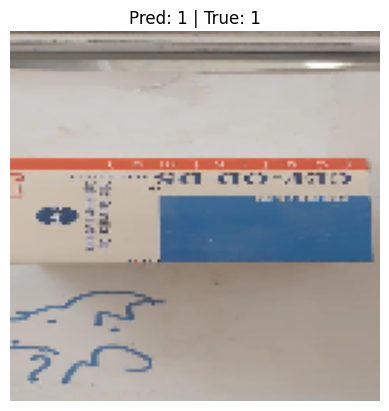

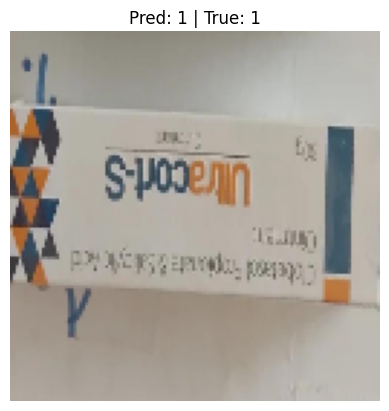

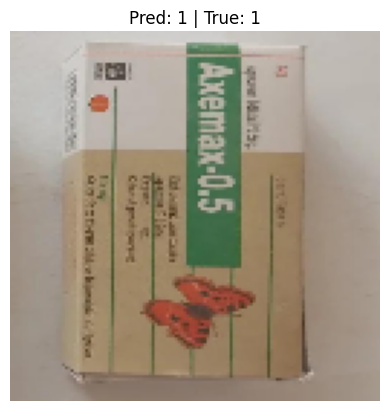

In [11]:
#Display predictions visually
# shows if our data is accurate
import numpy as np
import matplotlib.pyplot as plt

# Get one batch from validation data
images, labels = next(iter(val_data))

# Predict on that batch
preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display first 5 images with predictions
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Pred: {pred_classes[i]} | True: {true_classes[i]}")
    plt.axis('off')
    plt.show()